In [2]:
import numpy as np
from pprint import pprint
import sys, os
import matplotlib.pyplot as plt

import matplotlib
font = {'family' : 'sans-serif',
        'sans-serif': 'Arial',
        'style': 'normal',
        'weight': 'medium',
        'size'   : 10}
matplotlib.rc('font', **font)

sys.path.append('utils')
from SetupConnections import *
from NeuronCircuit import Circuit
from analysis_utils import baks
from neuron import h



%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

delay = 500.

ar = Arena('params/ca1_arenaparams_ripple.yaml')
ar.generate_population_firing_rates()
#ar.generate_cue_firing_rates('LEC', 1.0)

ar.generate_spike_times('CA3', dt=0.05, delay=delay)
ar.generate_spike_times('MEC', dt=0.05, delay=delay)
ar.generate_spike_times('LEC', dt=0.05, delay=delay, cued=False)
ar.generate_spike_times('Background', dt=0.05, delay=delay)


In [4]:
arena_size = ar.params['Arena']['arena size']
bin_size   = ar.params['Arena']['bin size']
mouse_speed = ar.params['Arena']['mouse speed']
nlaps       = ar.params['Arena']['lap information']['nlaps']

time_for_single_lap = arena_size / mouse_speed * 1000.
print(time_for_single_lap, nlaps)

6666.666666666667 4


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


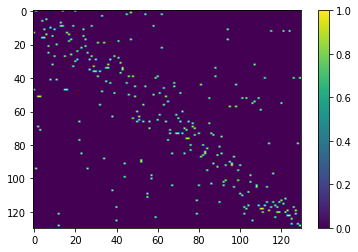

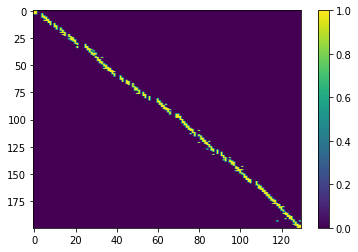

In [5]:
place_information = {'place ids': [0], 'place fracs': [0.80]}

diagram = WiringDiagram('params/ca1_circuitparams.yaml', place_information)
diagram.generate_internal_connectivity()

external_kwargs = {}
external_kwargs['place information'] = diagram.place_information
external_kwargs['external place ids'] = [100, 101]
external_kwargs['cue information'] = diagram.place_information
external_kwargs['external cue ids'] = [102]

diagram.generate_external_connectivity(ar.cell_information, **external_kwargs)
diagram.generate_septal_connectivity()

plt.figure()
plt.imshow(diagram.internal_adj_matrices[0][0], aspect='auto')
plt.colorbar()
plt.show()


plt.figure()
plt.imshow(diagram.external_adj_matrices[100][0], aspect='auto')
plt.colorbar()
plt.show()


In [6]:
def pull_spike_times(population2info_dict):
    spike_times = []
    gids = np.sort(list(population2info_dict.keys()))
    for gid in gids:
        spike_times.append(population2info_dict[gid]['spike times'])
    return spike_times

ca3_spike_times  = pull_spike_times(ar.cell_information['CA3']['cell info'])
mec_spike_times = pull_spike_times(ar.cell_information['MEC']['cell info'])
lec_spike_times = pull_spike_times(ar.cell_information['LEC']['cell info'])
bk_spike_times  = pull_spike_times(ar.cell_information['Background']['cell info'])

In [25]:
circuit = Circuit('params/ca1_circuitparams.yaml', diagram.pop2id, diagram.external_pop2id)
circuit.build_cells()
circuit.build_internal_netcons(diagram.internal_adj_matrices)
# circuit.build_external_netcons(100, diagram.external_adj_matrices[100], ca3_spike_times)
# circuit.build_external_netcons(101, diagram.external_adj_matrices[101], mec_spike_times)
# circuit.build_external_netcons(102, diagram.external_adj_matrices[102], lec_spike_times)
# circuit.build_external_netcons(103, diagram.external_adj_matrices[103], bk_spike_times)
circuit.record_lfp([0,1])


ripple_place_info = {}
ripple_place_info['gid'] = diagram.place_information[0]['place']
ripple_place_info['loc'] = [diagram.wiring_information['ca1pyr']['cell info'][gid]['soma position'] for gid in ripple_place_info['gid'] ]
ripple_start_times = circuit.build_ripples(mean_time=800., weight=4.0e-1, Tmax = 60000., duration=[40.,70.], 
                                           fraction_place_active=0.30, place_cell_info=ripple_place_info, 
                                           stim_freq=100., nspikes=1, delay=delay)


#circuit.build_septal_netcons(diagram.septal_adj_matrices)

In [26]:
from copy import deepcopy
def filter_spikes(spike_times, ripple_starts, step=100):
    updated_spike_times = []
    for i in range(len(spike_times)):
        current_spike_times = spike_times[i]
        updated = deepcopy(current_spike_times)
        for ripple_start in ripple_starts:
            updated = [st for st in updated if not ripple_start <= st <= ripple_start+step]
        updated_spike_times.append(updated)
    return updated_spike_times
            
# filtered_ca3_spike_times = filter_spikes(ca3_spike_times, ripple_start_times)
# filtered_mec_spike_times = filter_spikes(mec_spike_times, ripple_start_times)
# filtered_lec_spike_times = filter_spikes(lec_spike_times, ripple_start_times)
# filtered_bk_spike_times = filter_spikes(bk_spike_times, ripple_start_times)

        
circuit.build_external_netcons(100, diagram.external_adj_matrices[100], filtered_ca3_spike_times)
circuit.build_external_netcons(101, diagram.external_adj_matrices[101], filtered_mec_spike_times)
circuit.build_external_netcons(102, diagram.external_adj_matrices[102], filtered_lec_spike_times)
circuit.build_external_netcons(103, diagram.external_adj_matrices[103], filtered_bk_spike_times) 

4


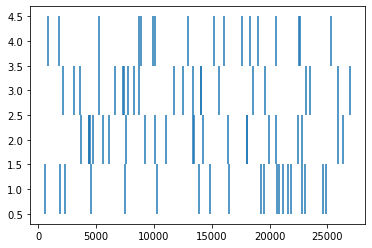

In [9]:
place_ids = diagram.place_information[0]['place']

for z in [place_ids[61]]:

    plt.figure()
    count = 0
    i = 0
    for nskeys in circuit.netstims[(100,0)].keys():
        if nskeys[1] == z:
            ns = circuit.netstims[(100,0)][(nskeys[0],nskeys[1])]
            count += len(ns)
            if len(ns) > 0:
                k = ns[0]
                plt.vlines(list(k[0]), i+0.5, i+1.5)
                i += 1
    print(count)


In [23]:
# this assumes plasticity is off

#model_filepath =  'models/48-trained-cue-on-inhplas-off-lecplas-off-15iter.npz'
#model_filepath =  'models/ca1-20iter-7232021-control.npz'

model_filepath =  'models/qan-ca1-7282021-control.npz'


f = np.load(model_filepath, allow_pickle=True)
fkeys = f.keys()
for fk in fkeys:
    try: fk = int(fk)
    except: 
        print('fail:',fk)
        continue

    population_info = circuit.neurons[fk]
    weights = f[str(fk)]
    counter = 0
    for cell_gid in population_info.keys():
        cell_info = population_info[cell_gid]
        for (presynaptic_gid, nc, _) in cell_info.internal_netcons:
            for netcon in nc:
                base_weight  = weights[counter]
                added_weight = weights[counter + 1]
                total_weight = base_weight + added_weight
#                 if fk == 0 and presynaptic_gid >= 130: 
#                     total_weight *= 0.50
                netcon.weight[0] = total_weight
                counter += 2
        for external_id in cell_info.external_netcons.keys():
            external_cell_info = cell_info.external_netcons[external_id]
            for (idx,(presynaptic_gid, nc, compartment)) in enumerate(external_cell_info):
                for netcon in nc:
                    base_weight  = weights[counter]
                    added_weight = weights[counter + 1]
                    total_weight = base_weight + added_weight
                    netcon.weight[0] = total_weight
                    counter += 2 
    print(len(weights), counter)
    

fail: frs
fail: spikes
fail: valid_gids
7400 7400
14760 14760


In [27]:
import time

h.load_file("stdrun.hoc")

def get_population_voltages(c,pop_id):
    v_vecs = []
    for i in range(len(c.neurons[pop_id])):
        v_vec = h.Vector()
        try:
            v_vec.record(c.neurons[pop_id][i].axon(0.5)._ref_v)
        except:
            v_vec.record(c.neurons[pop_id][i].soma(0.5)._ref_v)
        v_vecs.append(v_vec)
    return v_vecs

exc_v_vecs    = get_population_voltages(circuit, 0)
pvbc_v_vecs    = get_population_voltages(circuit, 1)
# aac_v_vecs   = get_population_voltages(2)
# bis_v_vecs   = get_population_voltages(3)
# olm_v_vecs   = get_population_voltages(4)
# isccr_v_vecs = get_population_voltages(5)
# iscck_v_vecs = get_population_voltages(6)

print('starting simulation..')
    
t_vec = h.Vector()  # Time stamp vector
t_vec.record(h._ref_t)

tic = time.time()

h.dt = 0.5
h.tstop =  time_for_single_lap * 1. + 500
h.finitialize(-65.0)
h.fadvance()
h.continuerun(h.tstop)

elapsed = time.time() - tic
print('that took %0.3f seconds' % elapsed)

starting simulation..
that took 218.991 seconds


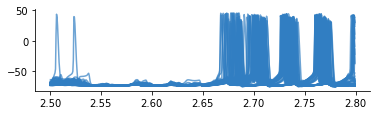

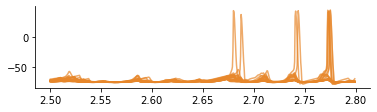

In [28]:
from analysis_utils import butter_bandpass_filter
from scipy.signal import welch, spectrogram

t_vec = np.asarray(t_vec)
s = np.where(t_vec > 2500)[0][0]
e = np.where(t_vec < 2800)[0][-1]


fig = plt.figure(figsize=(6,1.5))
ax  = fig.gca()
plt.plot(np.divide(t_vec[s:e], 1000.), np.asarray(exc_v_vecs).T[s:e, diagram.place_information[0]['place']],
         color=(49/255.,126/255.,194/255.), alpha=0.7)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)
    
fig = plt.figure(figsize=(6,1.5))
ax  = fig.gca()
plt.plot(np.divide(t_vec[s:e], 1000.), np.asarray(exc_v_vecs).T[s:e, diagram.place_information[0]['not place']], 
         color=(231/255.,135/255.,43/255.), alpha=0.7)
for axis in ['top','right']:
    ax.spines[axis].set_linewidth(0.0)

In [29]:
from analysis_utils import butter_bandpass_filter


lfp = circuit.lfp
lfp_np = np.asarray([np.asarray(l, dtype='float32') for l in lfp], dtype='float32')
print(lfp_np.shape)
lfp_mean = lfp_np.mean(axis=0)
lfp_filtered = butter_bandpass_filter(lfp_mean, 110.0, 310.0, 2000., order=3)


(629, 14334)


[1130.7933545818914, 2664.2804895503596, 3375.026510040177, 4022.229918517593, 7958.701959852332, 8567.77428046806, 10349.30453781541, 11968.936890161507, 14077.046670858297, 15288.167576566171]
0.005405219834760632 0.009952515327252909


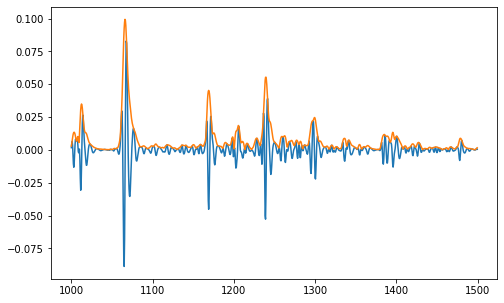

In [30]:
print(ripple_start_times[:10])


def get_envelope(x):
    from scipy.signal import hilbert
    hx = hilbert(x)
    return np.abs(hx)

#1000 - 1300
lfp_envelope = get_envelope(lfp_filtered)
emean = np.mean(lfp_envelope[1000:1300])
estd  = np.std(lfp_envelope[1000:1300])
print(emean, estd)


plt.figure(figsize=(8,5))
plt.plot(np.asarray(t_vec)[2000:3000],lfp_filtered[2000:3000])
plt.plot(np.asarray(t_vec)[2000:3000],lfp_envelope[2000:3000])


/mnt/d/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


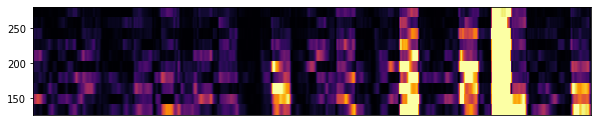

In [31]:


start = np.where(np.asarray(t_vec) > 5000+500)[0][0]
end   = np.where(np.asarray(t_vec) < 10000+500)[0][-1]

lfp_f, lfp_t, lfp_S = spectrogram(lfp_filtered[start:end], fs=2000., nperseg=128, noverlap=127)
fs, fe = np.where(lfp_f >= 120.0)[0][0], np.where(lfp_f <= 300)[0][-1]
lfp_S_reduced = lfp_S[fs:fe,:]
minn = np.percentile(lfp_S_reduced, 5.)
maxx = np.percentile(lfp_S_reduced, 95.)

plt.figure(figsize=(10,2))
plt.pcolormesh(lfp_t, lfp_f[fs:fe], lfp_S_reduced, vmin=minn, vmax=maxx, cmap='inferno')
#plt.colorbar()
plt.xticks([])
plt.show()


[1130.7933545818914, 2664.2804895503596, 3375.026510040177, 4022.229918517593, 7958.701959852332, 8567.77428046806, 10349.30453781541, 11968.936890161507, 14077.046670858297, 15288.167576566171, 16236.745227125912, 18690.333110885545, 20840.25238977469, 25639.322500391827, 26181.24126430523, 29700.817969727632, 30831.226817638413, 31530.162445681442, 32197.981091912417, 33557.77017570378, 35550.411432152374, 36234.09507504268, 37041.92079009346, 38838.45708637913, 39691.12524412144, 40417.34496037189, 42436.700571568996, 43628.39440307454, 44557.20111317013, 47405.86556353784, 48106.971869592664, 48893.62093338668, 49638.59550813915, 51845.44159147886, 56387.70110746061, 57232.22341901354, 57774.57205512819, 59212.52410648945, 60306.16265359539]


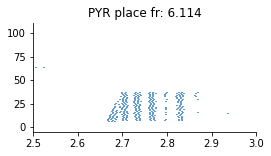

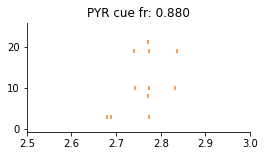

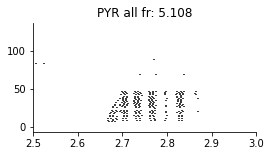

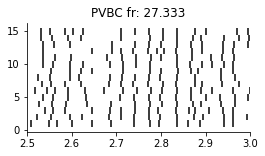

In [32]:
print(ripple_start_times)

def plot_spikes(c, population_id, title, start, finish, gids=None, color='k'):
    
    spike_times = c.get_cell_spikes(population_id)
    if gids is not None:
        temp_spike_times = []
        for i in range(len(spike_times)):
            if i in gids: temp_spike_times.append(np.divide(spike_times[i],1000.))
        spike_times = temp_spike_times
    else:
        spike_times = [np.divide(st, 1000.) for st in spike_times]
        
    frs = []
    fig = plt.figure(figsize=(4,2))
    ax = fig.gca()
    for (i,sts) in enumerate(spike_times):
        sts = np.asarray(sts)
        plt.vlines(np.asarray(sts), i+0.5, i+1.5, color=color)
        sts_chop = sts[np.where( (sts>=start/1000.) & (sts<=finish/1000.)) [0]]
        frs.append(float(len(sts_chop)) / float(finish-start) * 1000.)
    plt.xlim([start/1000., finish/1000.])
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0.0)
    plt.title('%s fr: %0.3f' % (title, np.mean(frs)))
    plt.show()
    return

start  = 2500#time_for_single_lap * 0 + 500
finish = 3000#time_for_single_lap * 1 + 500

plot_spikes(circuit, 0, 'PYR place', start, finish, gids=diagram.place_information[0]['place'], color=(49/255.,126/255.,194/255.))
plot_spikes(circuit, 0, 'PYR cue', start, finish, gids=diagram.place_information[0]['not place'], color=(231/255.,135/255.,43/255.))
plot_spikes(circuit, 0, 'PYR all', start, finish, gids=np.arange(130))
plot_spikes(circuit, 1, 'PVBC', start, finish, gids=None)

# plot_spikes(circuit, 2, 'AAC', start, finish)
# plot_spikes(circuit, 3, 'BiS', start, finish)
# plot_spikes(circuit, 4, 'OLM', start, finish)
# plot_spikes(circuit, 5, 'ISCCR', start, finish)
    

ripple lasted 100 timepoints 


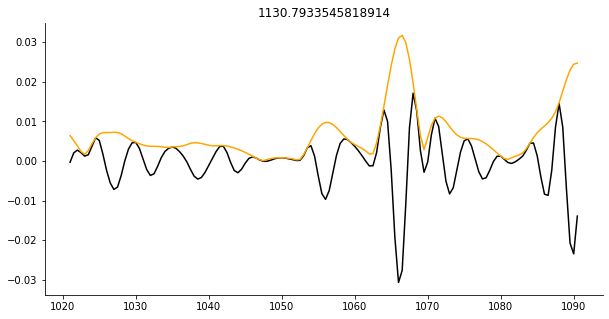

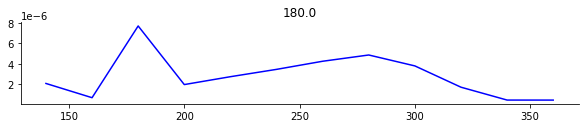

ripple lasted 100 timepoints 


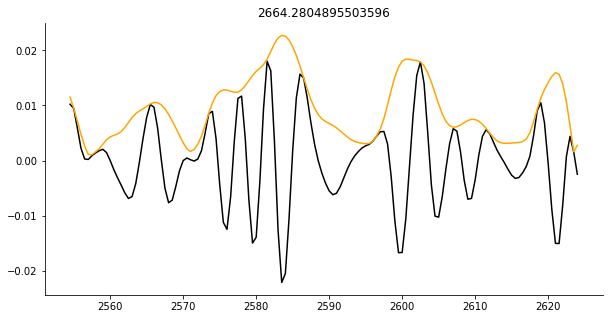

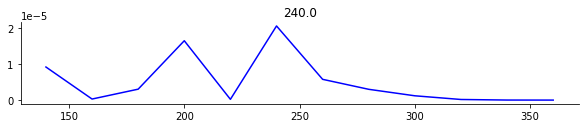

ripple lasted 100 timepoints 


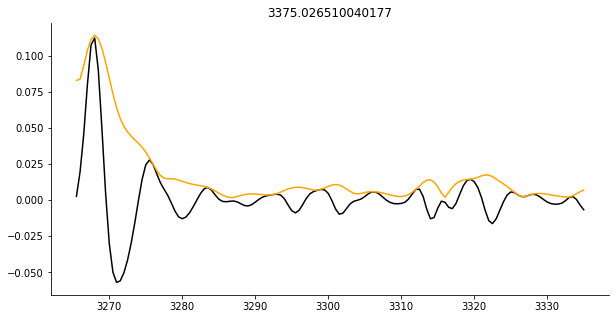

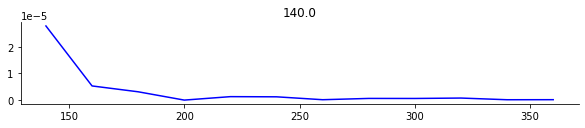

ripple lasted 100 timepoints 


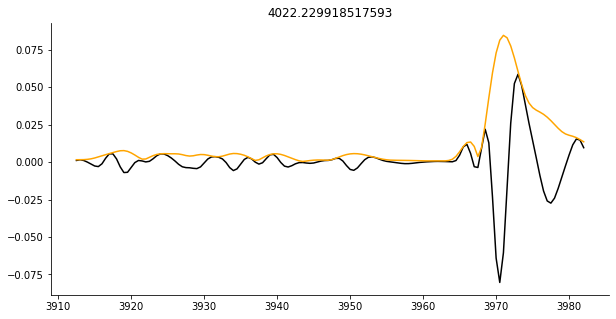

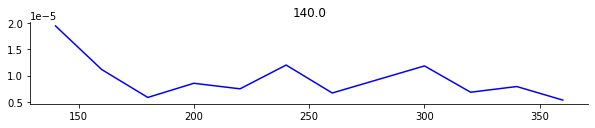

Text(0.5, 1.0, '4')

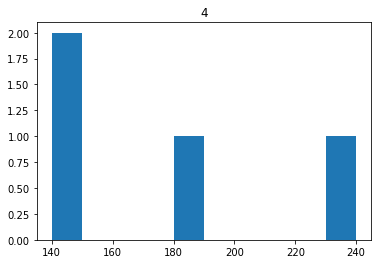

In [135]:
from scipy.signal import periodogram, welch

peaks, peak_powers, durations = [], [], []
for rst in ripple_start_times:
    try:
        start = np.where(np.asarray(t_vec) > rst)[0][0] - 200
        end   = start + 100
#         end = start + 100
#         for i in range(50):
#             if lfp_envelope[start+i] > emean + 5. * estd: 
#                 start = start + i
#                 break
#         end = start + 300
#         for i in range(300):
#             if lfp_envelope[start+i] <= emean + 5. * estd:
#                 end = start + i
#                 break
        durations.append(end-start)
        print('ripple lasted %i timepoints ' % (end-start))

        fig = plt.figure(figsize=(10,5))
        ax  = fig.gca()
        plt.plot(np.asarray(t_vec)[start-20:end+20], lfp_filtered[start-20:end+20], color='k')
        plt.plot(np.asarray(t_vec)[start-20:end+20], lfp_envelope[start-20:end+20], color='orange')
        for axis in ['top','right']:
            ax.spines[axis].set_linewidth(0.0)
        plt.title(rst)
        plt.show()

        lfp_ripple = lfp_filtered[start:end]
        f, p = periodogram(lfp_ripple, fs=2000., scaling='spectrum')
        rip_start = np.where(f>120)[0][0]
        rip_end   = np.where(f<400)[0][-1]


        frip, prip = f[rip_start:rip_end], p[rip_start:rip_end]
        peak_loc = np.argmax(prip)
        peak = frip[peak_loc]
        peaks.append(peak)


        fig = plt.figure(figsize=(10,1.5))
        ax  = fig.gca()
        plt.plot(f[rip_start:rip_end], p[rip_start:rip_end], color='b')
        plt.title(peak)
        for axis in ['top','right']:
            ax.spines[axis].set_linewidth(0.0)
        plt.show()
    except: continue

    peak_power = prip[peak_loc]
    peak_powers.append(peak_power)
plt.figure()
plt.hist(peaks)
plt.title(len(peaks))

#np.savez('ripple_analysis/ripple-b3ko-100hz-7282021.npz', peaks=peaks, power=peak_powers, durations=durations)


In [43]:

def make_stats(label):

    control_peaks_f = np.load('ripple_analysis/ripple-control-100hz-7282021.npz')
    control_peaks = control_peaks_f[label]

    b3ko_peaks_f = np.load('ripple_analysis/ripple-b3ko-100hz-7282021.npz')
    b3ko_peaks   = b3ko_peaks_f[label]

    fig = plt.figure(figsize=(2,2), dpi=600)
    ax  = fig.gca()
    plt.hist([control_peaks, b3ko_peaks], color=['gray', 'darkviolet'], edgecolor='k', linewidth=1)
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0.0)
    plt.show()

    from scipy.stats import mannwhitneyu, ttest_ind


    U, p = mannwhitneyu(control_peaks, b3ko_peaks,alternative='less')
    print(U, p)
    print('medians', np.median(control_peaks), np.median(b3ko_peaks))
    print('---')
    t, p = ttest_ind(control_peaks, b3ko_peaks)
    print(t, p/2.)
    print('means', np.mean(control_peaks), np.mean(b3ko_peaks))

    fig = plt.figure()
    ax  = fig.gca()
    vplot = plt.violinplot([control_peaks, b3ko_peaks], showextrema=False, showmeans=True)

    for i, (color, bodies) in enumerate(zip(['silver','darkviolet'], vplot['bodies'])):
        bodies.set_facecolor(color)
        bodies.set_edgecolor('k')
        bodies.set_linewidth(2)
        bodies.set_alpha(0.80)
        vp = vplot['cmeans']
        vp.set_edgecolor('k')
        vp.set_linewidth(3)
    ax.set_xticks([])
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0.0)
        

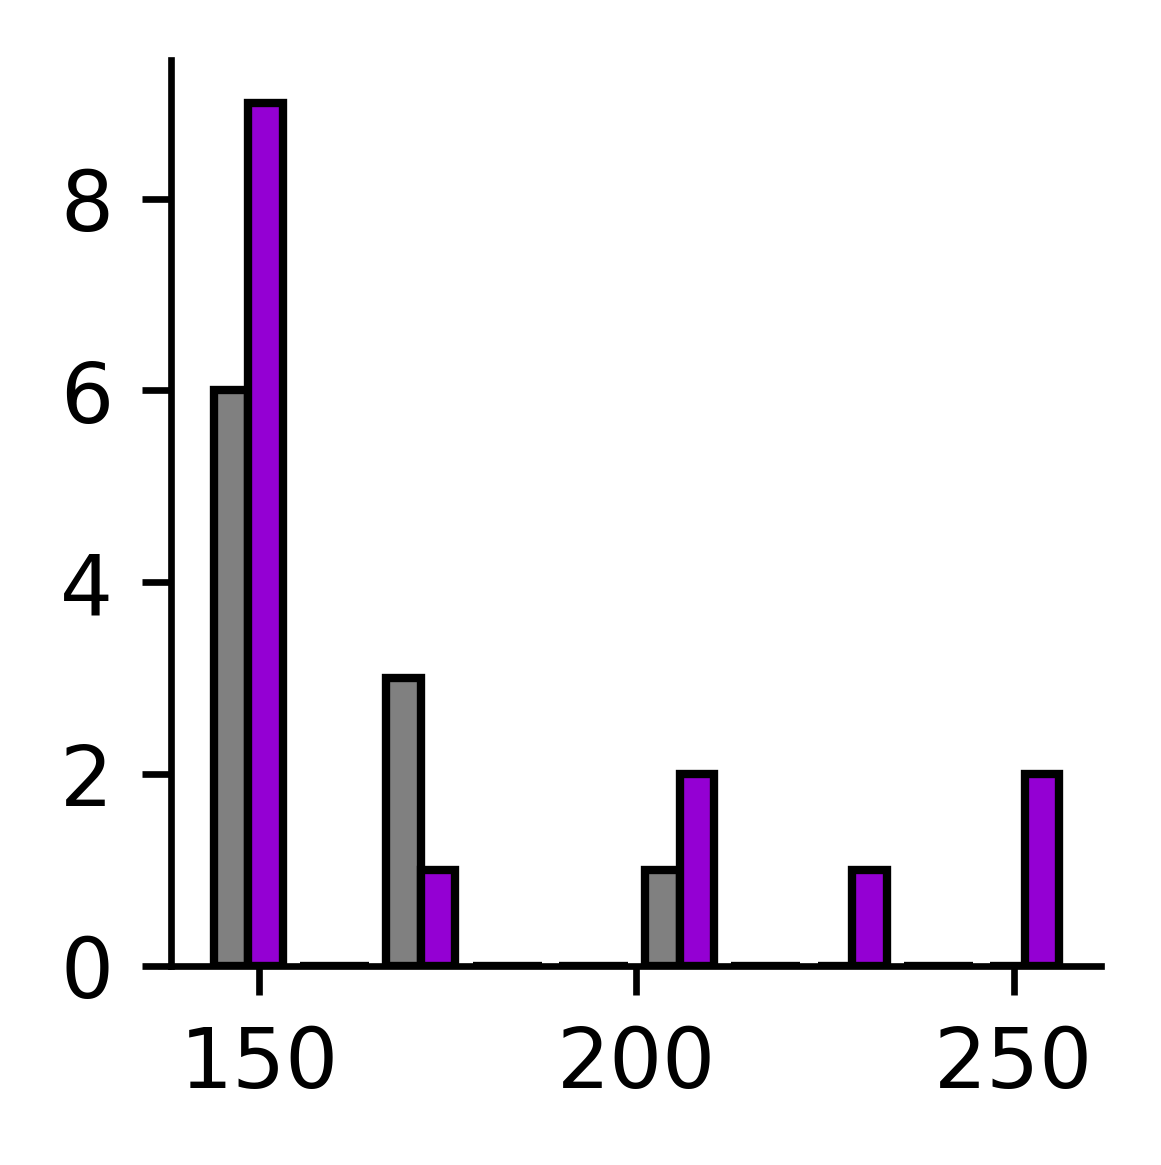

66.5 0.30754137633460255
medians 142.85714285714283 142.85714285714283
---
-1.0880227067977815 0.14392771391781908
means 157.1428571428571 173.33333333333331


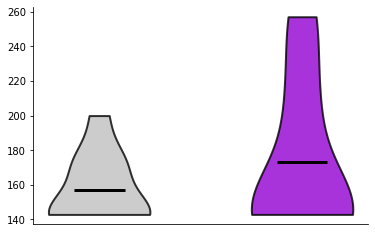

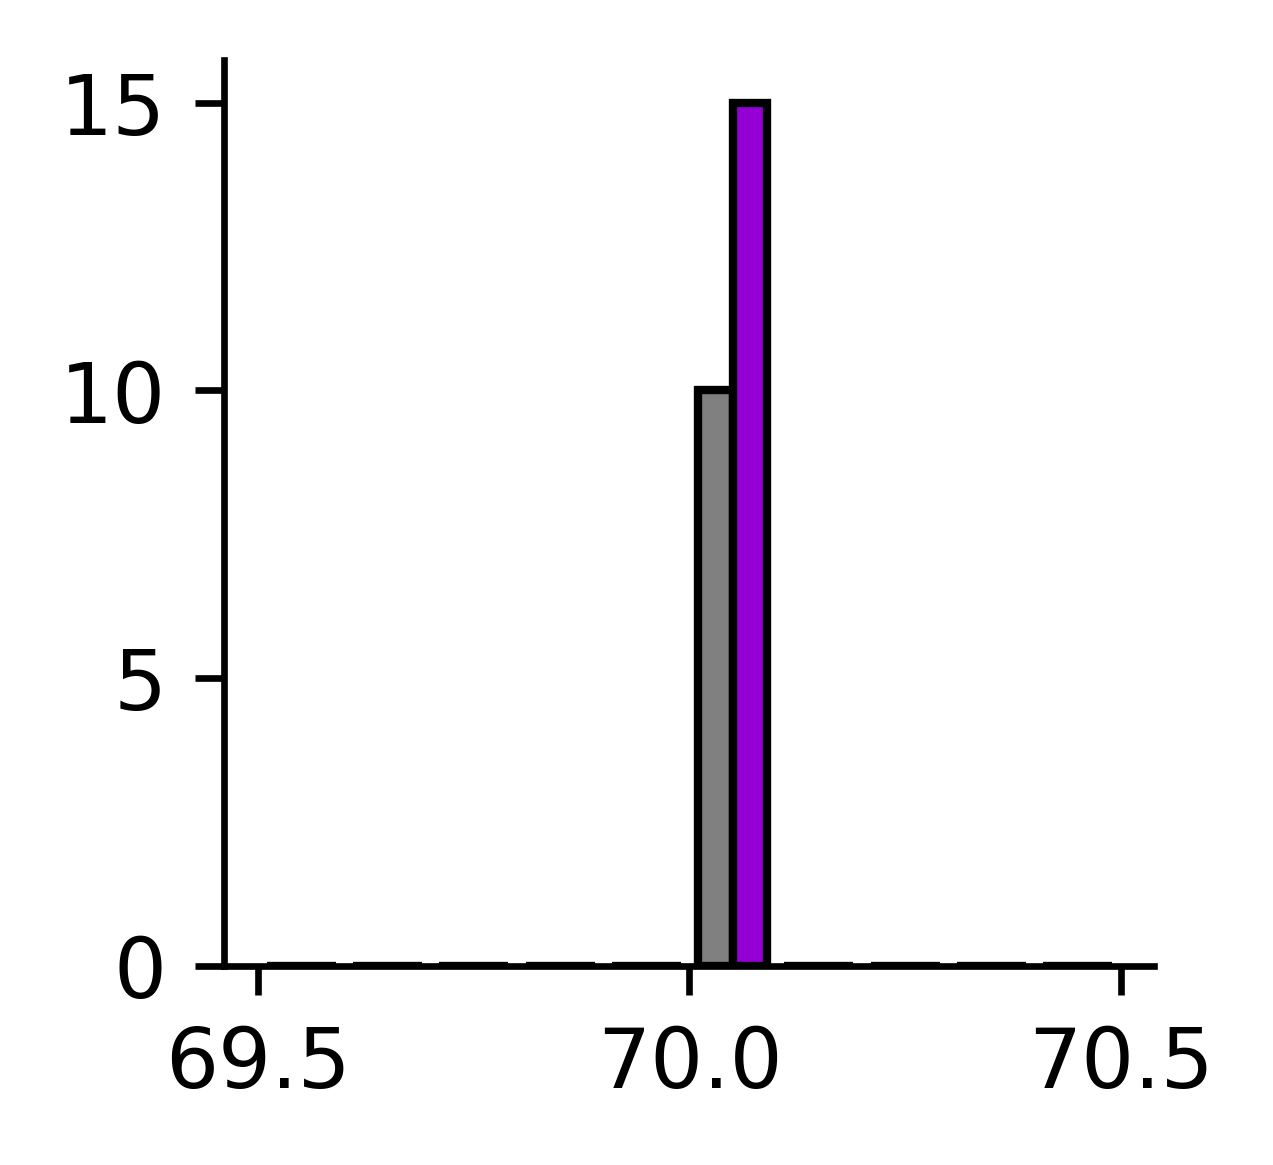

ValueError: All numbers are identical in mannwhitneyu

In [44]:
make_stats('peaks')
make_stats('durations')


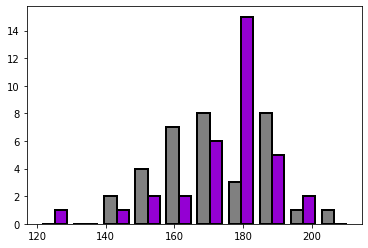

In [214]:
control_peaks_f1 = np.load('control-peaks.npz')
control_peaks1 = control_peaks_f1['peaks']

control_peaks_f2 = np.load('control-peaks-150.npz')
control_peaks2 = control_peaks_f2['peaks']

plt.figure()
plt.hist([control_peaks1, control_peaks2], color=['gray', 'darkviolet'], edgecolor='k', linewidth=2)
plt.show()


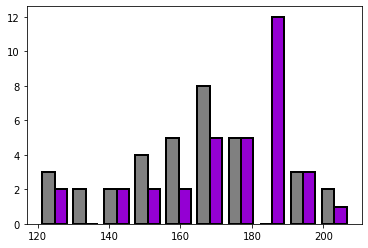

In [264]:
b3ko_peaks_f1 = np.load('b3ko-peaks.npz')
b3ko_peaks1 = b3ko_peaks_f1['peaks']

b3ko_peaks_f2 = np.load('b3ko-peaks-150.npz')
b3ko_peaks2 = b3ko_peaks_f2['peaks']

plt.figure()
plt.hist([b3ko_peaks1, b3ko_peaks2], color=['gray', 'darkviolet'], edgecolor='k', linewidth=2)
plt.show()


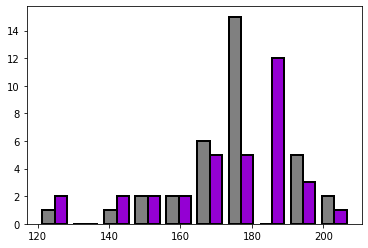

560.0 0.4142637193020524


In [268]:
plt.figure()
plt.hist([control_peaks2, b3ko_peaks2], color=['gray', 'darkviolet'], edgecolor='k', linewidth=2)
plt.show()


500.0 7166.666666666667


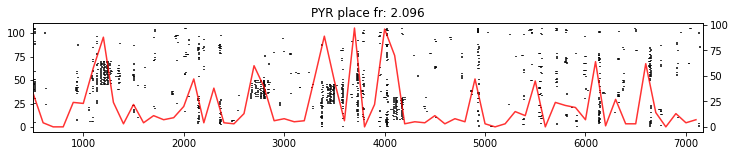

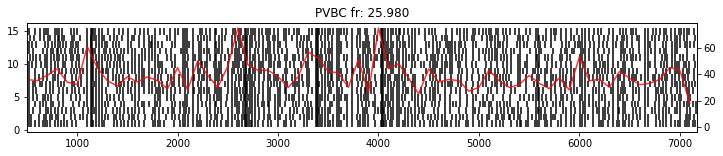

In [139]:
def plot_spikes(c, population_id, title, start, finish, gids=None, color='k'):
    spike_times = c.get_cell_spikes(population_id)
    if gids is not None:
        temp_spike_times = []
        for i in range(len(spike_times)):
            if i in gids:
                temp_spike_times.append(spike_times[i])
        spike_times = temp_spike_times
        
    frs = []
    fig, ax = plt.subplots(figsize=(12,2))
    for (i,sts) in enumerate(spike_times):
        sts = np.asarray(sts)
        ax.vlines(np.asarray(sts), i+0.5, i+1.5, color=color)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
    ax.set_xlim([start, finish])
    ax.set_title('%s fr: %0.3f' % (title, np.mean(frs)))
    
    ax2 = ax.twinx()
    
    tick = 0
    jump = 100 #25ms hops
    nspikes = []
    while tick < finish:
        curr_nspikes = 0
        for (i,sts) in enumerate(spike_times):
            tick_end = tick + jump
            sts = np.asarray(sts)
            sts_chop = sts[np.where( (sts>=tick) & (sts<=tick_end)) [0]]
            curr_nspikes += len(sts_chop)
        tick += jump
        nspikes.append(curr_nspikes)
    ax2.plot([i*jump for i in range(len(nspikes))],nspikes, color='r', alpha=0.8)
    ax2.set_xlim([start, finish])
    return nspikes

start  = time_for_single_lap * 0 + 500
finish = time_for_single_lap * 1 + 500
print(start, finish)

nspikes_place = plot_spikes(circuit, 0, 'PYR place', start, finish, diagram.place_information[0]['place'])
#nspikes_cue   = plot_spikes(circuit, 0, 'PYR cue', start, finish, diagram.place_information[0]['not place'])
#nspikes_total = plot_spikes(circuit, 0, 'PYR all', start, finish, np.arange(130))
nspikes_pvbc  = plot_spikes(circuit, 1, 'PVBC', start, finish)


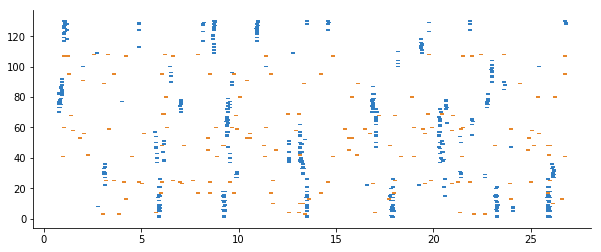

In [17]:
def plot_spikes(c, population_id, title, start, finish, gids=None, **kwargs):
    spike_times = c.get_cell_spikes(population_id)
    if gids is not None:
        temp_spike_times = []
        for i in range(len(spike_times)):
            if i in gids:
                temp_spike_times.append(np.divide(spike_times[i], 1000.))
        spike_times = temp_spike_times
        
    frs = []
    fig, ax = plt.subplots(figsize=(10,4))
    for (i,sts) in enumerate(spike_times):
        sts = np.asarray(sts)
        if i in kwargs['place ids']:
            color = kwargs['place colors']
        else:
            color = kwargs['cue colors']
        ax.vlines(np.asarray(sts), i+0.5, i+1.5, color=color, linewidth=4)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
    #ax.set_xlim([start/1000., finish/1000.])
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0.0)  

place_ids = diagram.place_information[0]['place']
place_colors = (49/255., 126/255., 194/255.)
cue_ids = diagram.place_information[0]['not place']
cue_colors = (231/255., 135/255., 43/255.)

kwargs = {'place ids': place_ids, 'place colors': place_colors, 'cue ids': cue_ids, 'cue colors': cue_colors} 
start = 18000
finish = 24000
plot_spikes(circuit, 0, 'PYR all', start, finish, np.arange(130), **kwargs)


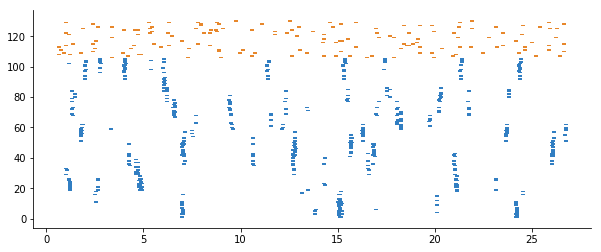

In [14]:
def plot_spikes(c, population_id, title, start, finish, gids=None, **kwargs):
    place_ids = kwargs['place ids']
    cue_ids   = kwargs['cue ids']
    
    spike_times = c.get_cell_spikes(population_id)
    if gids is not None:
        temp_spike_times = []
        for i in range(len(spike_times)):
            if i in gids:
                temp_spike_times.append(np.divide(spike_times[i], 1000.))
        spike_times = temp_spike_times
        
    frs = []
    fig, ax = plt.subplots(figsize=(10,4))
    count = 0
    for (i,pid) in enumerate(place_ids):
        sts = np.asarray(spike_times[pid])
        ax.vlines(np.asarray(sts), i+0.5, i+1.5, color=kwargs['place colors'], linewidth=4)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)
        count += 1
    for (i,cid) in enumerate(cue_ids):
        sts = np.asarray(spike_times[cid])
        ax.vlines(np.asarray(sts), i+count+0.5, i+count+1.5, color=kwargs['cue colors'], linewidth=4)
        sts_chop = sts[np.where( (sts>=start) & (sts<=finish)) [0]]
        frs.append(float(len(sts_chop)) / (finish-start) * 1000.)     
        
    
    #ax.set_xlim([start/1000., finish/1000.])
    for axis in ['top','right']:
        ax.spines[axis].set_linewidth(0.0)  

place_ids = diagram.place_information[0]['place']
place_colors = (49/255., 126/255., 194/255.)
cue_ids = diagram.place_information[0]['not place']
cue_colors = (231/255., 135/255., 43/255.)

kwargs = {'place ids': place_ids, 'place colors': place_colors, 'cue ids': cue_ids, 'cue colors': cue_colors} 
start = 10000
finish = 24000
plot_spikes(circuit, 0, 'PYR all', start, finish, np.arange(130), **kwargs)
